In [1]:
# from torch_geometric.nn import TopKPooling
# from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GINConv
from torch_geometric.nn import MLP
from torch.nn import ReLU
import torch
from torch.optim import Adam
from torch_geometric.data import DataLoader
import torch.nn.functional as F
import pickle
import numpy as np
import pandas as pd
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import BatchNorm1d
from torch.nn import Sequential
from torch_geometric.data import Data

/gpfs/gibbs/project/krishnaswamy_smita/sv496/conda_envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [3]:
import pickle as pk
out_path = '/home/sv496/project/flux_prediction/data/E.coli_data/'

with open(out_path+ 'aug_NN_features.pk', 'rb') as b:
    graph_obj = pk.load(b)

S_matrix = pd.read_csv(out_path + 'S_matrix.csv', index_col = 0)

In [4]:
bounds = graph_obj['bounds']
#BIOMASS SOLUTIONS
# solutions = graph_obj['solutions_biomass']
#MAX WEIGHTED CLIQUE SOLUTIONS
solutions = graph_obj['solutions_mwclique']

$RAG = \hat{S}^T \hat{S}$

 where $\hat{S}$ is boolean S_matrix

In [5]:
S_bool = S_matrix[S_matrix == 0].fillna(1).to_numpy()
RAG = np.matmul(np.transpose(S_bool), S_bool)
RAG = pd.DataFrame(RAG, index = S_matrix.columns, columns = S_matrix.columns)

In [6]:
edge_index = np.zeros([1,2])
for i, row in enumerate(RAG.index):
    for f, col in enumerate(RAG.columns):
        if RAG.iloc[i,f] > 0:
            p = ([i,f])
            edge_index = np.vstack([edge_index, p])
edge_index = edge_index[2:,:]

edge_index = edge_index.reshape(2,2204)
edge_index = torch.from_numpy(edge_index)
edge_index = edge_index.type(torch.LongTensor)

In [7]:
dictionary = {}
for i, curr_bounds in enumerate(bounds):

    x = torch.from_numpy(curr_bounds.reshape(95,2)).float() #both upper and lower bounds
    # x = torch.from_numpy(curr_bounds[:,0].reshape(95,1)).float() #just upper bound
    y = torch.from_numpy(solutions[i].reshape(95,1)).float()

    data = Data(x=x, y=y, edge_index=edge_index)
    key = "graph_"+str(i)
    dictionary[key] = data

In [8]:
dictionary['graph_0'].is_directed()

True

# Train-test split

In [9]:
from sklearn.model_selection import train_test_split

graph_names = list(dictionary.keys())
data_objects = list(dictionary.values())

test_size = 0.2

# Split the indices of the Data objects into training and testing sets
indices = list(range(len(data_objects)))
train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

train_data = {graph_names[i]: data_objects[i] for i in train_indices}
test_data = {graph_names[i]: data_objects[i] for i in test_indices}

# GNN Model

In [16]:
class GNN(torch.nn.Module):
    #Too large output_features: Make it 2 or 4.
    def __init__(self, input_features = 2, output_features = 4):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        # self.conv1 = GINConv(MLP(in_channels=2, hidden_channels=16,
        #   out_channels=16, num_layers=3))
        self.conv1 = GCNConv(in_channels = input_features, out_channels = 16)

        # self.conv2 = GINConv(MLP(in_channels=16, hidden_channels=16,
        #   out_channels=16, num_layers=3))
        self.conv2 = GCNConv(16, 16)

        # self.conv3 = GINConv(MLP(in_channels=16, hidden_channels=16,
        #   out_channels=16, num_layers=3))
        self.conv3 = GCNConv(16,16)

        self.rates = Linear(16, 1)

    def forward(self,data_x,data_edge_index):
        x = self.conv1(data_x,data_edge_index)
        #Maybe try dropout()
        x = x.relu()
        x = self.conv2(x,data_edge_index)
        #Remove this relu()
        x = x.relu()
        x = self.conv3(x,data_edge_index)

        output_data = self.rates(x)
        return output_data

In [19]:
#train function
#loop through the epochs (for hyperparameter tuning)
#Iterate over dataset and compute the loss
model = GNN()
#Change the optimizer to SGD.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#need to use nnl loss due to softmax being the final layer of the gnn
mse_loss = torch.nn.MSELoss()
#Load the data to be trained
training_data = DataLoader(dictionary)

def train(dictionary):
    for key,data in dictionary.items():
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index)
        # print(out.dtype)
        data.y = data.y.to(dtype = torch.float64)
        Smat = torch.from_numpy(S_bool).float()
        # print(out.dtype)
        stoich_ineq = torch.matmul(Smat, out.float())
        stoich_loss = mse_loss(stoich_ineq, torch.zeros(72))
        #Also run without the stoich loss
        loss = mse_loss(out.double(), data.y)#*(0.8) + stoich_loss*(0.2)
        # print(loss.dtype)
        globals()['stoich_ineq'] = stoich_ineq
        globals()['stoich_loss'] = stoich_loss
        globals()['out'] = out
        globals()['loss'] = loss



        # out = model(data.x, data.edge_index)  # Perform a single forward pass.
        # loss = mse_loss(out, data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.


In [20]:
training_losses = []
stoich_losses = []

for epoch in range(0,100):
    print('epoch ', epoch)
    # train(synth_dictionary)
    train(train_data)
    training_losses.append(loss.item())
    stoich_losses.append(stoich_loss.item())

epoch  0


/gpfs/gibbs/project/krishnaswamy_smita/sv496/conda_envs/metabolomics/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([72])) that is different to the input size (torch.Size([72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49
epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59
epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69
epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79
epoch  80
epoch  81
epoch  82
epoch  83
epoch  84
epoch  85
epoch  86
epoch  87
epoch  88
epoch  89
epoch  90
epoch  91
epoch  92
epoch  93
epoch  94
epoch  95
epoch  96
epoch  97
epoch  98
epoch  99


In [21]:
def test(test_data):
    #for epoch in range(epochs):
        #Iterate over the training data
    error = []
    count = 0
    loss = 0
    sum_y = 0
    for key,data in test_data.items():
        #Perform forward pass
        pred = model(data.x,data.edge_index)
        #Get predictions
        # predictions = edge_weight.argmax(dim=1)
        #correct count
        count += 1
        sum_y += torch.sum(data.y)
        # print(pred)
        loss += mse_loss(pred, data.y)
        # error.append(pred - data.y)
        
        # correct += int((pred == data.y).sum())
    # print(count)
    # print(sum_y)
    return loss/sum_y

In [22]:
test(test_data)

tensor(0.1501, grad_fn=<DivBackward0>)

# Visualization

In [23]:
import matplotlib.pyplot as plt

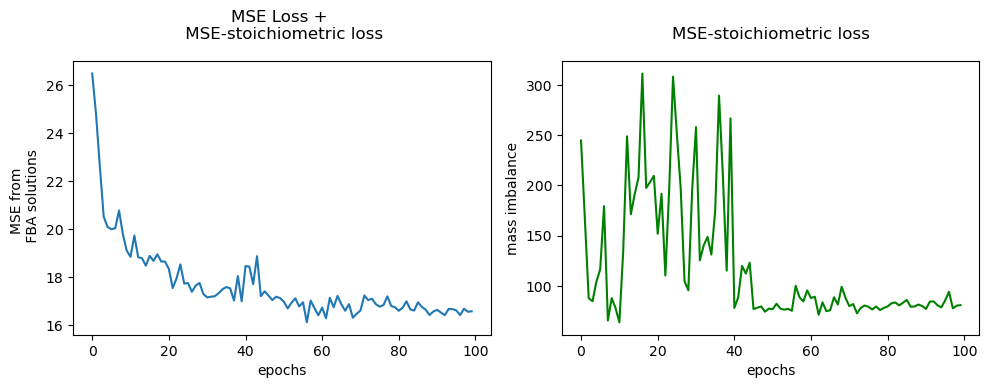

In [24]:
fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
epochs = range(0,len(training_losses))
ax.plot(epochs, training_losses)
ax.set_xlabel('epochs')
ax.set_ylabel("MSE from \n FBA solutions")
ax.set_title("MSE Loss + \n MSE-stoichiometric loss", y=1.05)

ax = axes[1]
ax.plot(epochs, stoich_losses, color= 'green')
ax.set_xlabel('epochs')
ax.set_ylabel("mass imbalance")
ax.set_title("MSE-stoichiometric loss", y=1.05)

fig.tight_layout()
# plt.savefig('toy_data_GNN_loss_graph.pdf', dpi=300)

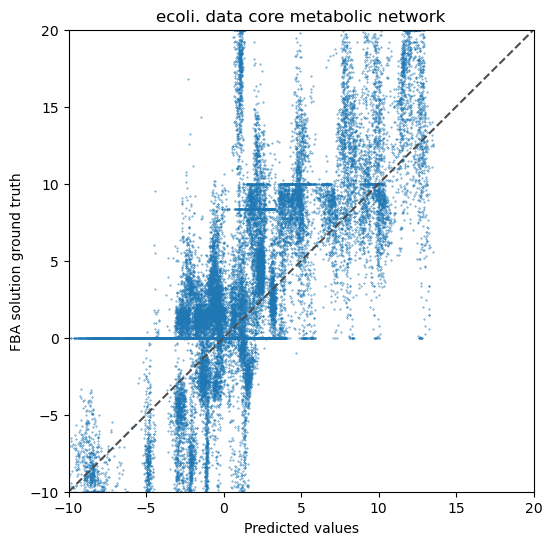

In [25]:
gt = []
pred = []

for key, data in test_data.items():
    out = model(data.x, data.edge_index)
    actual = data.y

    pred = np.append(pred, out.detach().numpy())
    gt = np.append(gt, actual.detach().numpy())
# pred = pred.reshape(-1,8)
# gt = gt.reshape(-1,8)

fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.scatter(x = pred.flatten(), y = gt.flatten(), s = 0.11)
ax.plot([-10, 20], [-10, 20], ls="--", c=".3")
ax.set(xlim=(-10, 20), ylim=(-10, 20))
ax.set_xlabel("Predicted values")
ax.set_ylabel("FBA solution ground truth")
ax.set_title("ecoli. data core metabolic network")
fig.show()
plt.savefig('ecoli_data_GNN.pdf', dpi=300)

In [26]:
gt.shape

(57285,)

In [27]:
pred.shape

(57285,)

In [28]:
from scipy.stats import pearsonr
pcc, _ = pearsonr(gt, pred)
print("Pearson Correlation Coefficient:", pcc)


Pearson Correlation Coefficient: 0.7324065357645977
